In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import zscore
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Loading Dataset
dataset = pd.read_csv(r"C:\Users\H\Battery\battery_ml.csv")

In [3]:
# Dataset parting into X and Y
X = dataset.drop(["cycle_life", "Unnamed: 0"], axis=1)
y = dataset["cycle_life"]

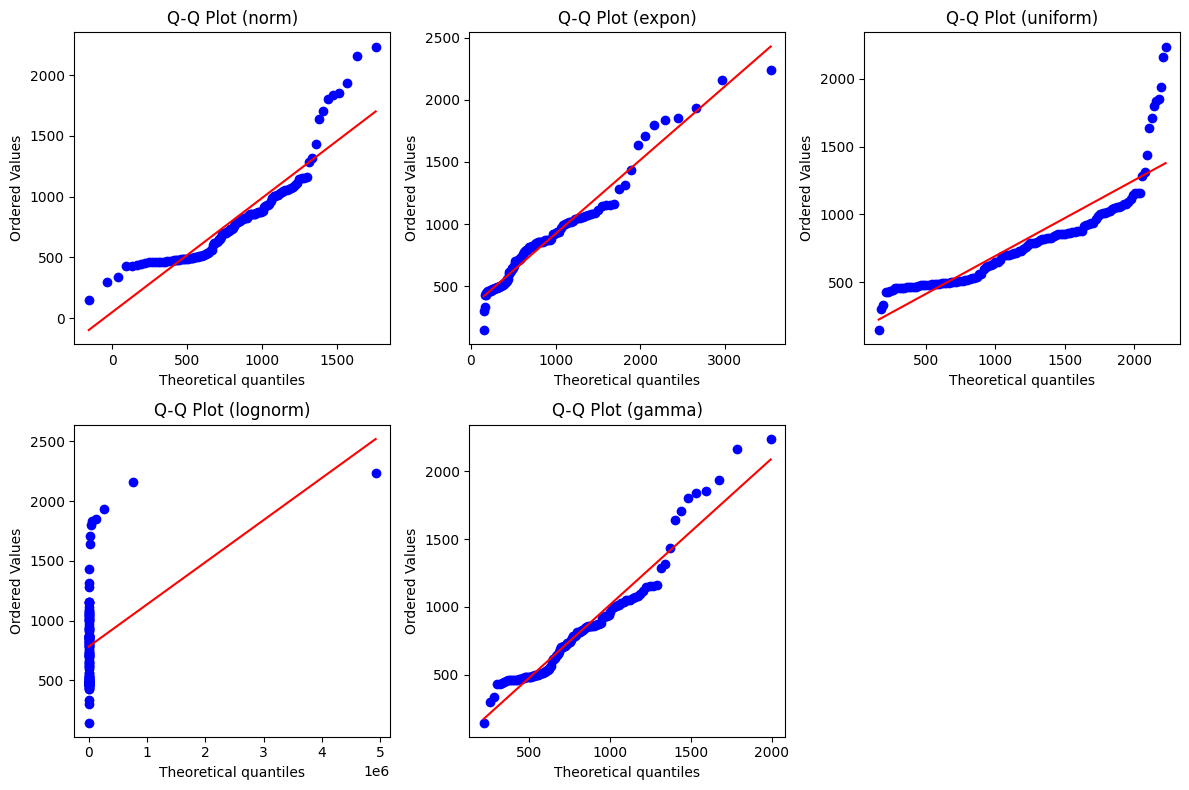

In [4]:
# Fitting dataset to a List of distributions
distributions = ['norm', 'expon', 'uniform', 'lognorm', 'gamma']


plt.figure(figsize=(12, 8))

for i, dist in enumerate(distributions, 1):
    plt.subplot(2, 3, i)
    
    dist_obj = getattr(stats, dist)
    params = dist_obj.fit(y)
    
    # Quantile-Quantile plot
    stats.probplot(y, dist=dist_obj, sparams=params, plot=plt)
    
    plt.title(f"Q-Q Plot ({dist})")

plt.tight_layout()
plt.show()


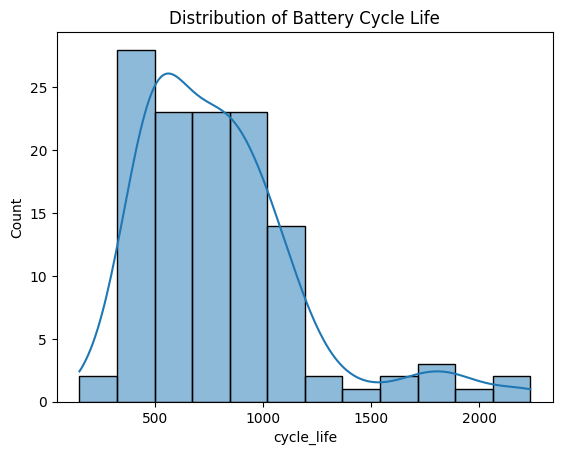

In [5]:
sns.histplot(y, kde=True)
plt.title("Distribution of Battery Cycle Life")
plt.show()


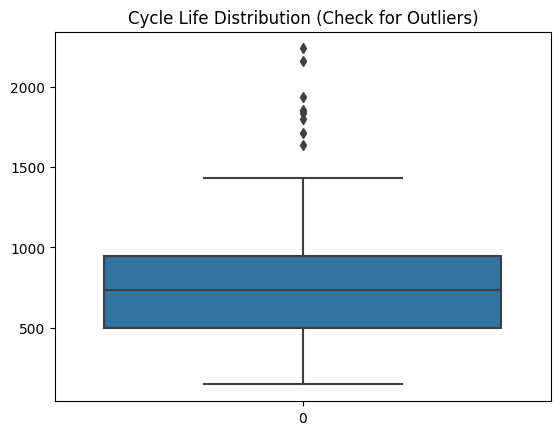

In [6]:
#Boxplot
sns.boxplot(y)
plt.title("Cycle Life Distribution (Check for Outliers)")
plt.show()

In [7]:
# Handling outliers using Winsorization
upper_limit = np.percentile(y, 95)
y = np.where(y > upper_limit, upper_limit, y)

print(f"Upper Cap (95th percentile): {upper_limit}")


# Find how many values exceed the limit
num_capped = np.sum(y > upper_limit)

# Apply capping
y_winsorized = np.where(y > upper_limit, upper_limit, y)

print(f"Number of training examples capped: {num_capped}")


# Normalize y using log transformation 
y_log = np.log1p(y)

Upper Cap (95th percentile): 1698.3499999999997
Number of training examples capped: 0


In [8]:
# y_sorted = np.sort(y) 

# y_log_sorted = np.log1p(y_sorted) 

# # Plot original vs log-transformed y
# plt.figure(figsize=(10, 5))

# # Original Y
# plt.plot(y_sorted, marker='o', linestyle='-', label="Original Y")

# # Log Transformed Y
# plt.plot(y_log_sorted, marker='o', linestyle='-', label="Log Transformed Y")

# plt.xlabel("Data Index")
# plt.ylabel("Value")
# plt.title("Effect of Log Transformation on Y")
# plt.legend()
# plt.grid(True)
# plt.show()

In [9]:
# Z-scale Normalizing features because features are of different scales
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 1.61599535,  1.44434523, -0.81725073, ...,  0.10031824,
        -1.41222747,  0.2159204 ],
       [ 1.4893108 ,  1.33454287, -0.81717395, ...,  0.36767974,
        -1.41222747,  0.29270323],
       [ 1.17996191,  1.2998775 , -0.78413515, ...,  0.21360715,
        -1.41222747,  0.3578677 ],
       ...,
       [ 0.83256909,  0.82874291, -0.62351667, ...,  1.72296865,
         0.81042108, -0.01050904],
       [ 0.74333138,  0.6959439 , -0.57169111, ..., -0.81897078,
         0.61411764,  0.14529704],
       [ 1.21673134,  1.06302431, -0.73894399, ..., -0.80178617,
         0.59894265,  0.20588585]])

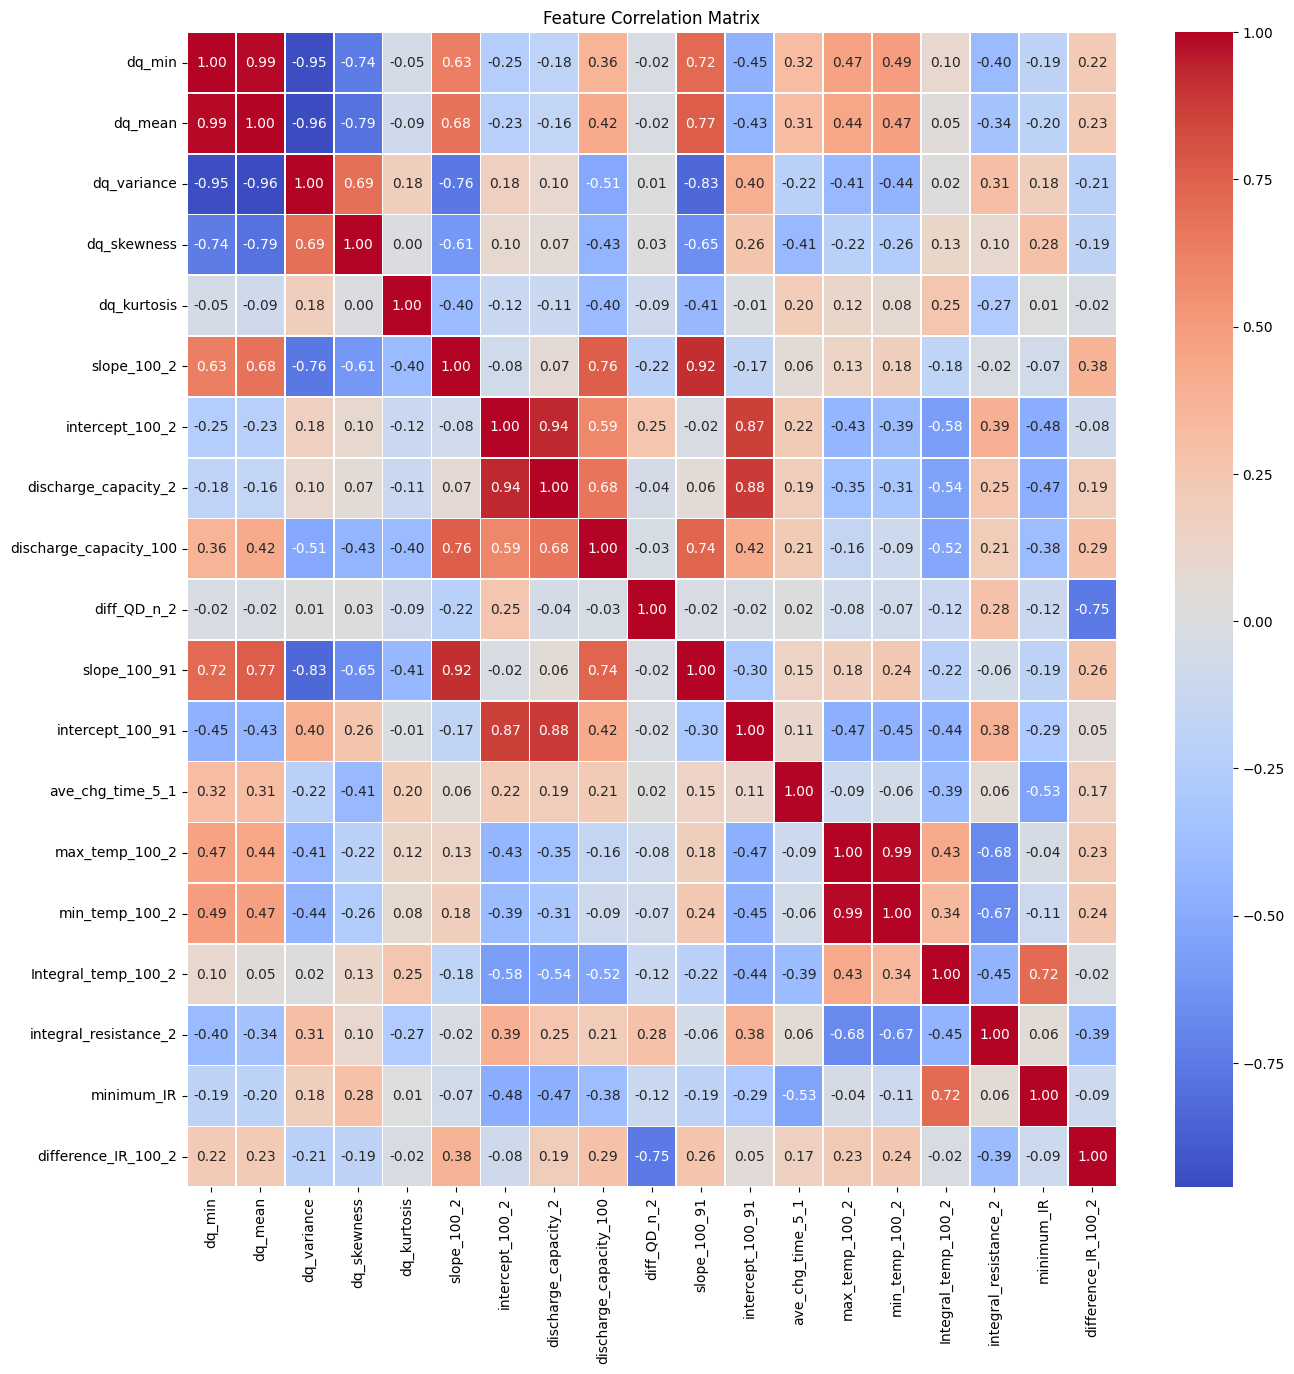

In [10]:
X_df = pd.DataFrame(X_scaled, columns=X.columns)

# correlation matrix
corr_matrix = X_df.corr()

# heatmap
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Matrix")
plt.show()


In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF for each feature
vif = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
pd.DataFrame({'Feature': X_df.columns, 'VIF': vif}).sort_values(by='VIF', ascending=False)

,Feature,VIF
10,slope_100_91,5945.191506
8,discharge_capacity_100,5369.051719
11,intercept_100_91,3679.526051
6,intercept_100_2,541.175152
5,slope_100_2,432.189620
1,dq_mean,406.147108
0,dq_min,242.967174
13,max_temp_100_2,147.901283
14,min_temp_100_2,138.495681
7,discharge_capacity_2,75.343846


In [12]:
# Spliting into training and final test set
X_train, X_final_test, y_train, y_final_test = train_test_split(X_scaled, y_log, test_size=24/124, random_state=42)


In [13]:
ridge = Ridge(alpha=1)


In [14]:
# Ridge Regression with Hyperparameter Tuning
param_grid = {"alpha": [0.1, 1, 50]}  # Test different alpha values
ridge_cv = GridSearchCV(Ridge(), param_grid, cv=10, scoring='r2')
ridge_cv.fit(X_train, y_train)

# Best model after tuning = best hyperparameters
best_ridge = ridge_cv.best_estimator_

# K-fold Cross-validation scores
kf = KFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(best_ridge, X_train, y_train, cv=kf, scoring='r2')

# Final Training on Best Model
best_ridge.fit(X_train, y_train)

# Predictions & Evaluation
y_train_pred = best_ridge.predict(X_train)  # Train Predictions

# Converting predictions back (inverse transform)
y_train_exp = np.expm1(y_train)         # Reverse log1p transform for train
y_train_pred_exp = np.expm1(y_train_pred)  


# Calculaing Errors
train_rmse = np.sqrt(mean_squared_error(y_train_exp, y_train_pred_exp))


print("Train RMSE:", train_rmse)

Train RMSE: 99.21556946575039


In [15]:
# Predicting on final test set
y_pred = best_ridge.predict(X_final_test)

# Convert predictions back to original scale (inverse log1p)
y_final_test_exp = np.expm1(y_final_test)
y_pred_exp = np.expm1(y_pred)

# Model performance metrics
print("Cross-validation R^2 scores:", cv_scores)
print("Mean R^2 score:", np.mean(cv_scores))
print("Final Test R^2 Score:", r2_score(y_final_test_exp, y_pred_exp))
print("Final Test RMSE:", np.sqrt(mean_squared_error(y_final_test_exp, y_pred_exp)))

Cross-validation R^2 scores: [0.85338201 0.79753151 0.87960895 0.94933876 0.78972487 0.85279278
 0.7610837  0.91528257 0.82960353 0.85546077]
Mean R^2 score: 0.8483809461152394
Final Test R^2 Score: 0.8568335036129788
Final Test RMSE: 158.11198836781372


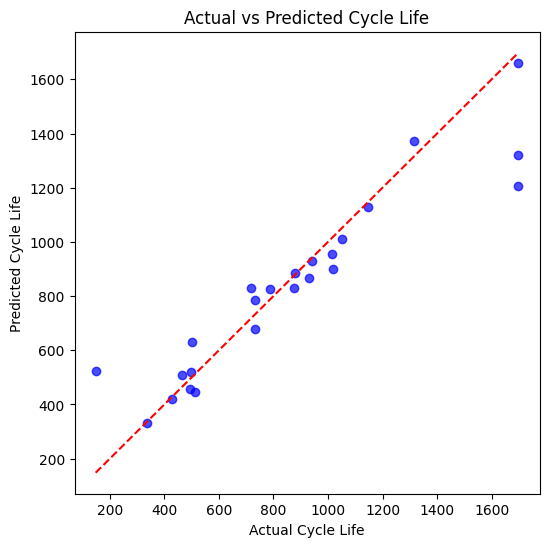

In [16]:
plt.figure(figsize=(6, 6))
plt.scatter(y_final_test_exp, y_pred_exp, alpha=0.7, color='blue')
plt.plot(
    [min(y_final_test_exp), max(y_final_test_exp)], 
    [min(y_final_test_exp), max(y_final_test_exp)], 
    color='red', linestyle='--')
plt.xlabel("Actual Cycle Life")
plt.ylabel("Predicted Cycle Life")
plt.title("Actual vs Predicted Cycle Life")
plt.show()

In [17]:
#comparision of predicted and actual values for validation set 
comparison_df = pd.DataFrame({'Actual': y_final_test_exp, 'Predicted': y_pred_exp})
print(comparison_df.head(24)) 

     Actual    Predicted
0   1014.00   955.387041
1    148.00   522.761505
2   1051.00  1012.392752
3    499.00   518.146617
4    494.00   455.712504
5   1698.35  1205.577270
6    502.00   629.252054
7    940.00   929.155406
8    786.00   827.379114
9   1698.35  1320.917223
10   731.00   678.180705
11  1146.00  1129.325715
12   335.00   330.820718
13   932.00   866.057049
14  1017.00   900.905131
15   429.00   418.577419
16   880.00   886.939659
17  1315.00  1371.076004
18   719.00   828.367050
19   731.00   787.105559
20   511.00   444.560774
21   466.00   509.892294
22  1698.35  1659.312823
23   876.00   828.138120
